In [68]:
#Torch import
import torch
from torch import nn
from torch.utils.data import random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F


import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
train_path = "/data/train.csv"

In [70]:
test_path = "/data/test.csv"

# EDA

In [71]:
train_df = pd.read_csv(train_path)

In [72]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Remove unnecessary data

In [73]:
train_df.dropna(subset=["keyword","location"], inplace=True)

In [74]:
train_df

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


### Sample tweet

In [75]:
print(train_df[train_df["target"] == 0])

         id  keyword                       location  \
32       49   ablaze  Est. September 2012 - Bristol   
34       52   ablaze               Philadelphia, PA   
35       53   ablaze                     London, UK   
36       54   ablaze                       Pretoria   
39       57   ablaze                 Paranaque City   
...     ...      ...                            ...   
7575  10826  wrecked                             TN   
7577  10829  wrecked         #NewcastleuponTyne #UK   
7579  10831  wrecked              Vancouver, Canada   
7580  10832  wrecked                        London    
7581  10833  wrecked                        Lincoln   

                                                   text  target  
32    We always try to bring the heavy. #metal #RT h...       0  
34                   Crying out for more! Set me ablaze       0  
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0  
36    @PhDSquares #mufc they've built so much hype a...       0  
39       

In [76]:
print(train_df[train_df["target"] == 1])

         id   keyword                   location  \
31       48    ablaze                 Birmingham   
33       50    ablaze                     AFRICA   
37       55    ablaze               World Wide!!   
46       66    ablaze  GREENSBORO,NORTH CAROLINA   
50       73    ablaze   Sheffield Township, Ohio   
...     ...       ...                        ...   
7541  10782  wreckage            New Delhi,India   
7542  10783  wreckage               Xi'an, China   
7543  10784  wreckage                     Mumbai   
7552  10795   wrecked             Santa Cruz, CA   
7572  10823   wrecked              Manhattan, NY   

                                                   text  target  
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...       1  
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...       1  
37    INEC Office in Abia Set Ablaze - http://t.co/3...       1  
46    How the West was burned: Thousands of wildfire...       1  
50    Deputies: Man shot before Brighton home

## Histogram

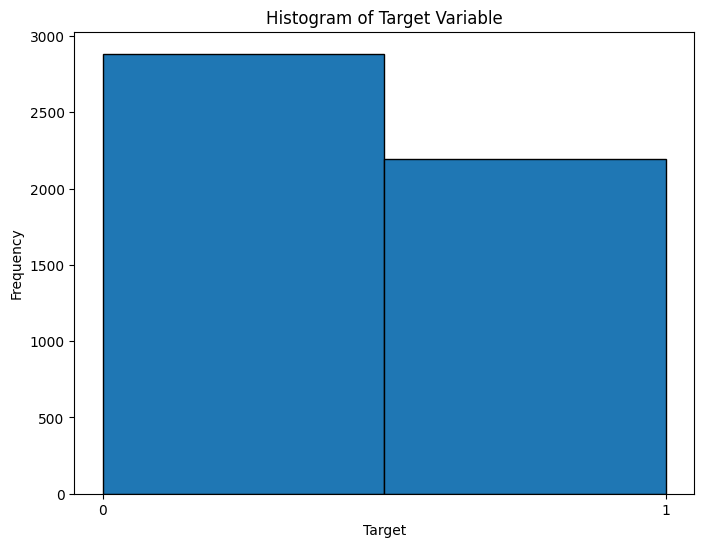

In [77]:
plt.figure(figsize=(8, 6))
plt.hist(train_df['target'], bins=2, edgecolor='black')
plt.title('Histogram of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['0', '1'])
plt.show()

### Plan of action

In [78]:
from collections import Counter
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm

class Vocabulary:
    """Class for constructing and managing a vocabulary for tweets text datasets."""

    def __init__(self, freq_threshold):
        """
        Initialize the Vocabulary with a frequency threshold.

        Args:
            freq_threshold (int): A word's minimum frequency must be included in the vocabulary.
        """
        self.freq_threshold = freq_threshold
        self.idx2str = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.str2idx = {value: key for key, value in self.idx2str.items()}
    
    def __len__(self):
        """ Returns the size of the vocabulary.x`"""
        return len(self.idx2str)
    
    @staticmethod
    def tokenizer_eng(text):
        """
        Tokenize the input text.

        Args:
            Text (str): The input text to tokenize.

        Returns:
            List: A list of tokenized and lowercase words.
        """
        tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
        return [tok.lower() for tok in tokenizer.tokenize(text) if tok.strip()]
    
    def build_vocabulary(self, sentence_list):
        """
        Build the vocabulary dictionary from a list of sentences.

        Args:
            sentence_list (list of str): A list of sentences to build the vocabulary from.
        """
        frequencies = Counter()
        start_idx = len(self.idx2str)
        
        # Update word frequencies
        for sentence in tqdm(sentence_list, desc="Building vocabulary", total=len(sentence_list)):
            frequencies.update(Counter(self.tokenizer_eng(sentence)))
        
        # Filter words based on frequency threshold
        filtered_words = {word for word, count in frequencies.items() if count >= self.freq_threshold}
        
        # Add filtered words to vocabulary
        self.str2idx.update({word: idx for idx, word in enumerate(filtered_words, start_idx)})
        self.idx2str.update({idx: word for idx, word in enumerate(filtered_words, start_idx)})
    
    def numericalize(self, text):
        """
        Convert text to a list of indices based on the vocabulary.

        Args:
            Text (str): The input text to convert.

        Returns:
            List: A list of indices corresponding to the words in the input text.
        """
        tokens = self.tokenizer_eng(text)
        return [self.str2idx.get(word, self.str2idx["<UNK>"]) for word in tokens]

### Dataset

In [79]:
class TweetClassifierDataset(Dataset):
    def __init__(self, df, text_vocab, keyword_vocab, location_vocab, num_words=100, transform=None, is_test=False):
        self.df = df
        self.num_words = num_words
        self.text = df['text'].tolist()
        self.keyword = df['keyword'].tolist()
        self.location = df['location'].tolist()
        self.ids = df['id'].tolist()  # Include IDs
        self.transform = transform
        self.text_vocab = text_vocab
        self.keyword_vocab = keyword_vocab
        self.location_vocab = location_vocab
        self.is_test = is_test
        
        # Build vocabularies from the dataset if needed
        self.text_vocab.build_vocabulary(self.text)
        self.keyword_vocab.build_vocabulary(self.keyword)
        self.location_vocab.build_vocabulary(self.location)
        
        if not is_test:
            self.target = df['target'].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tweet = self.text[idx]
        keyword = self.keyword[idx]
        location = self.location[idx]
        id_ = self.ids[idx]  # Get the ID
        
        if not self.is_test:
            target = self.target[idx]
            target = torch.tensor(target)
        else:
            target = torch.tensor(-1)  # Placeholder for test data, not used in inference
        
        if self.transform:
            tweet = self.transform(tweet)
       
        text_numericalized = self.text_vocab.numericalize(tweet)
        keyword_numericalized = self.keyword_vocab.numericalize(keyword)
        location_numericalized = self.location_vocab.numericalize(location)
        
        # Padding or truncating
        if len(text_numericalized) < self.num_words:
            text_numericalized.extend([self.text_vocab.str2idx["<PAD>"]] * (self.num_words - len(text_numericalized)))
        else:
            text_numericalized = text_numericalized[:self.num_words]
        
        text_numericalized = torch.tensor(text_numericalized)
        keyword_numericalized = torch.tensor(keyword_numericalized)
        location_numericalized = torch.tensor(location_numericalized)

        return {
            'id': id_,  # Include ID in the return
            'text': text_numericalized,
            'keyword': keyword_numericalized,
            'location': location_numericalized,
            'target': target  # Optional for test
        }

### Dataloader

## Model Defintion

Using a Bi-LSTM model.

In [80]:
import torch
import torch.nn as nn

class TweetClassifier(nn.Module):
    def __init__(self, output_size, vocab_size, embedding_dim, hidden_dim, num_layers, kernels, num_filters, keyword_vocab_size, location_vocab_size):
        super(TweetClassifier, self).__init__()
        
        # Embedding layers
        self.text_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.keyword_embedding = nn.Embedding(keyword_vocab_size, embedding_dim)
        self.location_embedding = nn.Embedding(location_vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer for LSTM output
        self.lstm_fc = nn.Linear(hidden_dim, hidden_dim)  # Ensure this matches the hidden_dim
        
        # CNN layers
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (K, embedding_dim)) for K in kernels
        ])
        
        # Calculate the total number of features after concatenation
        total_features = hidden_dim + len(kernels) * num_filters
        
        # Fully connected layer for combined output
        self.fc = nn.Linear(total_features, output_size)
        
    def forward(self, text, keyword, location):
        # Embedding lookups
        text_embeds = self.text_embedding(text)
        keyword_embeds = self.keyword_embedding(keyword)
        location_embeds = self.location_embedding(location)
        
        # LSTM Processing
        lstm_input = text_embeds
        lstm_out, (hn, _) = self.lstm(lstm_input)
        lstm_out = self.lstm_fc(hn[-1])  # Use the last hidden state
        
        # CNN Processing
        combined_embeds = torch.cat([text_embeds, keyword_embeds, location_embeds], dim=1)
        combined_embeds = combined_embeds.unsqueeze(1)  # Add channel dimension
        
        conv_outs = [torch.relu(conv(combined_embeds)).squeeze(3) for conv in self.convs]
        pooled_outs = [torch.max(out, dim=2)[0] for out in conv_outs]
        
        # Concatenate LSTM output and CNN outputs
        combined_out = torch.cat([lstm_out] + pooled_outs, dim=1)
        
        # Final fully connected layer
        out = self.fc(combined_out)
        
        return out

## Train

#### Utility functions

In [93]:
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# General Params
add_lr_scheduler = True
output_size = 1
batch_size = 512
n_epochs = 5

# Embedding params
num_words = 100
vocab_size = 7581
embedding_dim = 728

# CNN Params
kernels = (2, 3, 4, 5)
num_filters = 8  # 8 ==> 16

# LSTM Params
hidden_dim = 256
num_layers = 2

# Load data
data_df = pd.read_csv(train_path)
data_df.dropna(subset=["keyword","location"], inplace=True)

# Assuming your DataFrame has 'text', 'target', 'keyword', and 'location' columns
X = data_df[['id', 'text', 'keyword', 'location']]  # Features (tweets, keywords, locations)
y = data_df['target']  # Labels (targets)

# Split the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine the features and target back into DataFrames
train_df = pd.concat([x_train, y_train], axis=1)
valid_df = pd.concat([x_valid, y_valid], axis=1)

# Initialize vocabularies for text, keyword, and location
text_vocab = Vocabulary(freq_threshold=5)
keyword_vocab = Vocabulary(freq_threshold=5)
location_vocab = Vocabulary(freq_threshold=5)

# Define any transform if required (can be None)
transform = None

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, text_vocab, keyword_vocab, location_vocab, num_words):
    # Extract features and targets
    ids = [item['id'] for item in batch]
    texts = [item['text'] for item in batch]
    keywords = [item['keyword'] for item in batch]
    locations = [item['location'] for item in batch]

    # Pad sequences to max length in the batch
    max_text_len = num_words  # Assuming fixed length padding/truncating for text
    text_padded = torch.full((len(texts), max_text_len), fill_value=text_vocab.str2idx["<PAD>"], dtype=torch.long)
    
    for i, text in enumerate(texts):
        text_len = len(text)
        if text_len > max_text_len:
            text_len = max_text_len
        text_padded[i, :text_len] = text[:text_len]

    # Assuming keyword and location tensors are of the same length
    max_keyword_len = max(len(keyword) for keyword in keywords)
    max_location_len = max(len(location) for location in locations)
    
    keyword_padded = torch.full((len(keywords), max_keyword_len), fill_value=keyword_vocab.str2idx["<PAD>"], dtype=torch.long)
    location_padded = torch.full((len(locations), max_location_len), fill_value=location_vocab.str2idx["<PAD>"], dtype=torch.long)

    for i, keyword in enumerate(keywords):
        keyword_len = len(keyword)
        if keyword_len > max_keyword_len:
            keyword_len = max_keyword_len
        keyword_padded[i, :keyword_len] = keyword[:keyword_len]

    for i, location in enumerate(locations):
        location_len = len(location)
        if location_len > max_location_len:
            location_len = max_location_len
        location_padded[i, :location_len] = location[:location_len]

    # Handle targets if they exist
    targets = None
    if 'target' in batch[0]:
        targets = torch.tensor([item['target'] for item in batch], dtype=torch.float32)

    return {
        'id': ids,
        'text': text_padded,
        'keyword': keyword_padded,
        'location': location_padded,
        'target': targets
    }
# Create the dataset for training
train_dataset = TweetClassifierDataset(
    df=train_df, 
    text_vocab=text_vocab, 
    keyword_vocab=keyword_vocab, 
    location_vocab=location_vocab, 
    num_words=num_words, 
    transform=transform
)

# Create the dataset for validation
valid_dataset = TweetClassifierDataset(
    df=valid_df, 
    text_vocab=text_vocab, 
    keyword_vocab=keyword_vocab, 
    location_vocab=location_vocab, 
    num_words=num_words, 
    transform=transform
)

# Create DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, text_vocab=text_vocab, keyword_vocab=keyword_vocab, location_vocab=location_vocab, num_words=num_words)
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, text_vocab=text_vocab, keyword_vocab=keyword_vocab, location_vocab=location_vocab, num_words=num_words)
)

# Model
# Model
model = TweetClassifier(
    output_size=output_size,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    kernels=kernels,
    num_filters=num_filters,
    keyword_vocab_size=len(keyword_vocab),
    location_vocab_size=len(location_vocab)
).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()  # Assuming binary classification

# Optional: Learning rate scheduler
if add_lr_scheduler:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_running_loss = 0
    train_running_acc = 0
    
    tqdm_train_iterator = tqdm(enumerate(train_loader),
                               desc=f"[train] {epoch+1}/{n_epochs}",
                               ascii=True, leave=True,
                               total=len(train_loader),
                               colour="green", position=0)
    
    for batch_idx, batch in tqdm_train_iterator:
        text = batch['text'].to(device)
        keyword = batch['keyword'].to(device)
        location = batch['location'].to(device)
        target = batch['target'].to(device)
        
        optimizer.zero_grad()
        y_pred = model(text, keyword, location)  # Pass all features to the model
        
        # Assuming binary classification with logits; apply sigmoid if needed
        if output_size == 1:
            y_pred = torch.sigmoid(y_pred)

        # Ensure target is of type Float
        target = target.unsqueeze(1).float()  # Shape: [batch_size, 1]
        
        # Calculate loss
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
                
        if add_lr_scheduler:
            scheduler.step()  # Step the scheduler if used
        
        # Compute accuracy
        if output_size == 1:
            train_running_acc += ((y_pred > 0.5).float() == target).sum().item() / target.size(0)
        else:
            # For multi-class, use the correct accuracy computation
            train_running_acc += get_accuracy_without_softmax(y_pred.detach(), target)
        
        train_running_loss += loss.item()
        
        tqdm_train_iterator.set_postfix(
            avg_train_acc=f"{train_running_acc / (batch_idx + 1):0.4f}",
            avg_train_loss=f"{train_running_loss / (batch_idx + 1):0.4f}"
        )
    
    # Validation phase
    model.eval()
    valid_running_loss = 0
    valid_running_acc = 0
    
    with torch.no_grad():
        for batch in valid_loader:
            text = batch['text'].to(device)
            keyword = batch['keyword'].to(device)
            location = batch['location'].to(device)
            target = batch['target'].to(device)
            
            y_pred = model(text, keyword, location)
            
            if output_size == 1:
                y_pred = torch.sigmoid(y_pred)
            
            target = target.unsqueeze(1).float()  # Shape: [batch_size, 1]
            
            # Calculate loss
            loss = criterion(y_pred, target)
            
            # Compute accuracy
            if output_size == 1:
                valid_running_acc += ((y_pred > 0.5).float() == target).sum().item() / target.size(0)
            else:
                valid_running_acc += get_accuracy_without_softmax(y_pred.detach(), target)
            
            valid_running_loss += loss.item()
    
    print(f"[Validation] Epoch {epoch+1}/{n_epochs} - Loss: {valid_running_loss / len(valid_loader):.4f}, Accuracy: {valid_running_acc / len(valid_loader):.4f}")

print("Training complete.")



Building vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4064/4064 [00:00<00:00, 15524.98it/s]

Building vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4064/4064 [00:00<00:00, 67167.83it/s]

Building vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4064/4064 [00:00<00:00, 48653.35it/s]

Building vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1016/1016 [00:00<00:00, 13817.23it/s]

Building vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1016/1016 [00:00<00:00, 66175.12it/s]

[train] 1/5: 100%|###############################

[Validation] Epoch 1/5 - Loss: 0.7187, Accuracy: 0.5707


[train] 2/5: 100%|###############################################################################################| 8/8 [02:00<00:00, 15.12s/it, avg_train_acc=0.5667, avg_train_loss=0.7167]


[Validation] Epoch 2/5 - Loss: 0.7177, Accuracy: 0.5707


[train] 3/5: 100%|###############################################################################################| 8/8 [02:06<00:00, 15.76s/it, avg_train_acc=0.5670, avg_train_loss=0.7165]


[Validation] Epoch 3/5 - Loss: 0.7176, Accuracy: 0.5707


[train] 4/5: 100%|###############################################################################################| 8/8 [02:08<00:00, 16.01s/it, avg_train_acc=0.5668, avg_train_loss=0.7164]


[Validation] Epoch 4/5 - Loss: 0.7176, Accuracy: 0.5707


[train] 5/5: 100%|###############################################################################################| 8/8 [02:24<00:00, 18.11s/it, avg_train_acc=0.5668, avg_train_loss=0.7164]


[Validation] Epoch 5/5 - Loss: 0.7176, Accuracy: 0.5707
Training complete.


In [94]:
#Load test data
test_df = pd.read_csv(test_path)
test_df.dropna(subset=["keyword","location"], inplace=True)

In [95]:
test_df

,id,keyword,location,text
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...
17,51,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...
19,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...
...,...,...,...,...
3246,10804,wrecked,Love Reiss,@yakubOObs think he deactivated because his no...
3247,10806,wrecked,Seattle Washington,RT CNBC '3 words from Disney CEO Bob Iger wrec...
3248,10807,wrecked,Acey mountain islanddåÇTorontoåÈ,Smackdown tyme this should put me in a good mo...
3249,10816,wrecked,los angeles,@thrillhho jsyk I haven't stopped thinking abt...


In [100]:
# Initialize vocabularies for text, keyword, and location
text_vocab = Vocabulary(freq_threshold=1)
keyword_vocab = Vocabulary(freq_threshold=1)
location_vocab = Vocabulary(freq_threshold=1)

# Create the test dataset
test_dataset = TweetClassifierDataset(
    df=test_df,
    text_vocab=text_vocab,
    keyword_vocab=keyword_vocab,
    location_vocab=location_vocab,
    num_words=num_words,
    transform=transform,
    is_test=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, text_vocab=text_vocab, keyword_vocab=keyword_vocab, location_vocab=location_vocab, num_words=num_words)
)

# Ensure the model is in evaluation mode
model.eval()
# Initialize lists to store results
results = []

with torch.no_grad():
    for batch in test_loader:
        ids = batch['id']
        text = batch['text'].to(device)
        keyword = batch['keyword'].to(device)
        location = batch['location'].to(device)

        # Forward pass
        outputs = model(text, keyword, location)

        # Assuming binary classification with logits; apply sigmoid if needed
        if output_size == 1:
            outputs = torch.sigmoid(outputs)

        # Convert outputs to numpy and collect results
        predictions = outputs.cpu().numpy()
        # Collect results with IDs
        for id_, prediction in zip(ids, predictions):
            results.append({'id': id_, 'target': prediction[0]})  # Flatten prediction if necessary

# Create a DataFrame with results
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv('predictions.csv', index=False)



Building vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2158/2158 [00:00<00:00, 13071.16it/s]

Building vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2158/2158 [00:00<00:00, 74781.95it/s]

Building vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2158/2158 [00:00<00:00, 51344.74it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM_STREAM_MISMATCH